Does Gender Affect Churn?

In [50]:
gender_churn = pd.crosstab(df['gender'], df['Churn'])

#chi-square test
chi2, p, _, _ = chi2_contingency(gender_churn)
print(f"Chi-square test (gender vs churn): chi2 = {chi2:.2f}, p-value = {p:.4f}")

Chi-square test (gender vs churn): chi2 = 0.48, p-value = 0.4905


Does Tenure Differ by Churn?

In [51]:
tenure_yes = df[df['Churn'] == 'Yes']['tenure']
tenure_no = df[df['Churn'] == 'No']['tenure']

#T-test
t_stat, p_val = ttest_ind(tenure_yes, tenure_no)
print(f"T-test (tenure vs churn): t-stat = {t_stat:.2f}, p-value = {p_val:.4f}")

T-test (tenure vs churn): t-stat = -31.74, p-value = 0.0000


Data Modeling

In [52]:
#Encoding
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
for col in binary_cols:
    df[col] = df[col].map({'Male': 0, 'Female': 1, 'Yes': 1, 'No': 0})

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

multi_cols = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)

#Feature and target
X = df.drop('Churn', axis=1)
y = df['Churn']

#Split into training 80% and testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling all numbers so big values don’t dominate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Clustering Customer Segmentation

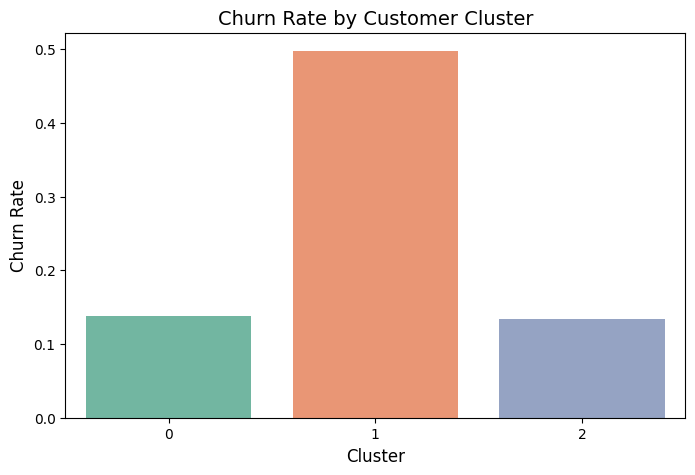

In [55]:
# Group customers into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaler.fit_transform(X))

# Plot churn rate per cluster
plt.figure(figsize=(8, 5))
sns.barplot(x='Cluster', y='Churn', data=df, palette='Set2', ci=None)
plt.title('Churn Rate by Customer Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.show()

# Simplify data to 2D for a scatterplot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


Scatterplot of clusters

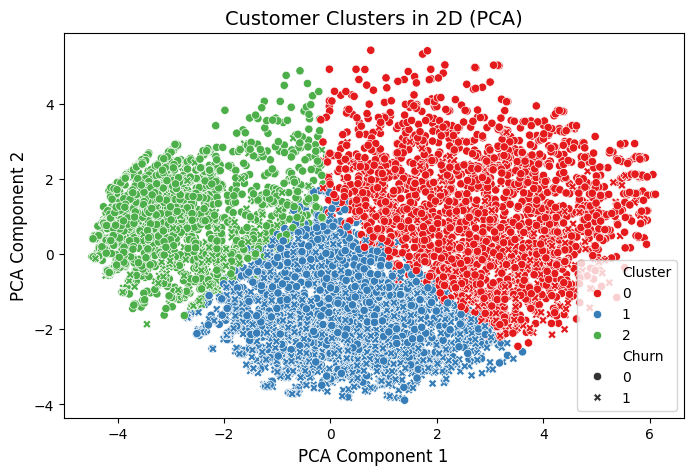

In [56]:
# Scatterplot of clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', style='Churn', data=df, palette='Set1')
plt.title('Customer Clusters in 2D (PCA)', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.show()

Survival Analysis

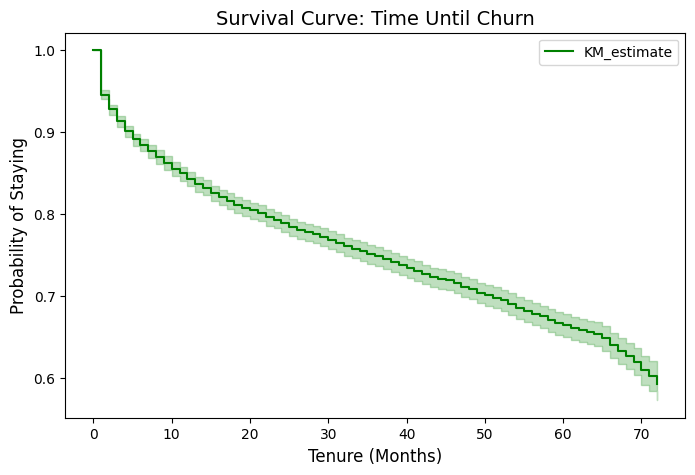

In [58]:
#Overall survival curve
kmf = KaplanMeierFitter()
kmf.fit(durations=df['tenure'], event_observed=df['Churn'])
plt.figure(figsize=(8, 5))
kmf.plot_survival_function(color='green')
plt.title('Survival Curve: Time Until Churn', fontsize=14)
plt.xlabel('Tenure (Months)', fontsize=12)
plt.ylabel('Probability of Staying', fontsize=12)
plt.show()


Survival by contract type

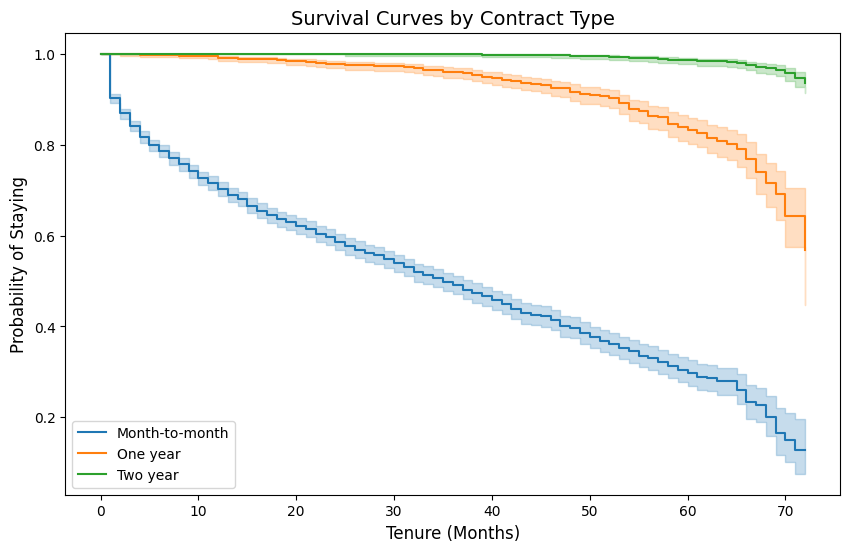

In [59]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
for contract in ['Month-to-month', 'One year', 'Two year']:
    if contract == 'Month-to-month':
        mask = (df['Contract_One year'] == 0) & (df['Contract_Two year'] == 0)
    elif contract == 'One year':
        mask = df['Contract_One year'] == 1
    else:
        mask = df['Contract_Two year'] == 1
    kmf.fit(durations=df[mask]['tenure'], event_observed=df[mask]['Churn'], label=contract)
    kmf.plot_survival_function(ax=ax)
plt.title('Survival Curves by Contract Type', fontsize=14)
plt.xlabel('Tenure (Months)', fontsize=12)
plt.ylabel('Probability of Staying', fontsize=12)
plt.show()